***
<center><h1>Face Rhythm</h1></center>

***

<table><tr>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723283221-5Z5038AT7Y6KCOM2PIU4/Screenshot+from+2021-03-02+17-05-12.png?content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723856628-J89PYYSF7K7JATE2KMF9/Screenshot+from+2021-03-02+17-23-46.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723931026-OORV0RAPZNWV3R8TBOXB/Screenshot+from+2021-03-02+17-25-11.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614724055033-O3GBEF1D9MULFZKI2IUJ/Screenshot+from+2021-03-02+17-27-10.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723378405-WXN74ZTT1KYZUQGDM07X/face_rhythm_banner2.png?format=1000w&content-type=image%2Fpng" style="height: 200px"> </td>
</tr></table>

***

##### Notebook Shortcuts
- **[Notebook Setup](#Notebook-Setup)**: Prepare all the necessary config files and folders
- **[Set ROI](#Set-ROI)**: Set the ROI for the analysis
- **[Run Optic Flow](#Run-Optic-Flow)**: Run the optic flow analysis
- **[Clean Optic Flow](#Clean-Optic-Flow)**: Optic flow post-processing
- **[Convolutional Dimensionality Reduction](#Convolutional-Dimensionality-Reduction)**: Convolutional Dimensionality Reduction
- **[Analysis](#Analysis)**: Decompose and Analyze the optic flow data in many ways
- **[Comparisons](#Comparisons)**: Compare Face Rhythm to some peer algorithms

***

# Tips on running this notebook:
In theory it would be nice if you could just enter the path of the video(s) and just let it run all the way through. In practice, there are a few hoops to jump through
- Run the Notebook Setup Block (two blocks below this one). This should pretty much always be done, even if you are loading precomputed file from disk instead of calculating them. This step loads in some useful meta data used throughout.
- Even if you are restarting at a specific point in your analysis, run your Setup Block then head down to your current analysis step cell 

# Project Directory Organization
------------

    Project Directory
    ├── config.yaml           <- Configuration parameters to run each module in the pipeline. Dictionary.
    ├── run_info.json         <- Output information from each module. Dictionary.
    │
    ├── run_data              <- Output data from each module.
    │   ├── Dataset_videos.h5 <- Output data from Dataset_videos class. Contains metadata about the videos.
    │   ├── ROIs.h5           <- Output data from ROIs class. Contains ROI masks.
    │   ├── PointTracker.h5   <- Output data from PointTracker class. Contains point tracking data.
    |   ├── VQT_Analyzer.h5   <- Output data from VQT_Analyzer class. Contains spectral decomposition data.
    │   ├── TCA.h5            <- Output data from TCA class. Contains TCA decomposition data.
    │   
    └── visualizations        <- Output visualizations.
        ├── factors_rearranged_[frequency].png  <- Example of a rearranged factor plot.
        └── point_tracking_demo.avi             <- Example video.



***
<center><h1>Notebook Setup</h1></center>

***

### Creates config and locates videos

**Crucially, always run this first cell every time you run this notebook.**

Also, generally make sure to read through the config parameters before running.

The Project path is the path to a folder (existing or not) where we will store our derived files. I recommend creating a project folder and then copying this notebook into that folder.
The Video path is the path to a folder containing videos. 
The run name will determine the name of the config. You might create multiple configs if you want to re-run the same data with slightly different parameters

Previous face rhythm users might be familiar with the 'sessions' structure. Some users will want to run multiple sessions through Face Rhythm at the same time. If that's you, then read the docs to see what parameters to change:
https://face-rhythm.readthedocs.io/

If you did everything according to the readme, you should see that the video_path currently points to a folder containing one sample video in the testing folder. Give this a try!

In [1]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2
import face_rhythm as fr

from pprint import pprint
from pathlib import Path

import cv2

import numpy as np
import torch
import matplotlib.pyplot

fr.util.get_system_versions(verbose=True);

Operating System: Linux: 5.15.0-69-generic, #76~20.04.1-Ubuntu SMP Mon Mar 20 15:54:19 UTC 2023, x86_64, node: rich-L-CLASS
Conda Environment: FR
Python Version: 3.9.13
GCC Version: 9.4.0
PyTorch Version: 1.13.1+cu116
CUDA Version: 11.6, CUDNN Version: 8302, Number of Devices: 1, Devices: ['device 0: Name=NVIDIA GeForce RTX 3090, Memory=25.403129856 GB'], 
Numpy Version: 1.23.2
OpenCV Version: 4.6.0
face-rhythm Version: 0.1.0


In [2]:
directory_project = '/media/rich/bigSSD/analysis_data/face_rhythm/churchland_data/from_20230429_slack/cam1'
directory_videos  = '/media/rich/bigSSD/other lab data/Churchland data/from_20230502'

filename_strMatch = 'cam1.*avi'  ## You can use regular expressions to search and match more complex strings

In [3]:
path_config, path_run_info, directory_project = fr.project.prepare_project(
    directory_project=directory_project,
    overwrite_config=False,  ## WARNING! CHECK THIS.
    mkdir=True,    
    initialize_visualization=True,    
    verbose=2,
)
figure_saver = fr.util.Figure_Saver(
    path_config=path_config,
    format_save=['png'],
    kwargs_savefig={'bbox_inches': 'tight', 'pad_inches': 0.1, 'transparent': True, 'dpi': 300},
    overwrite=False,
    verbose=2,
)

Initializing cv2.imshow
FR: Found config.yaml file at /media/rich/bigSSD/analysis_data/face_rhythm/churchland_data/from_20230429_slack/cam1/config.yaml


# Prepare video data for point tracking

In [4]:
paths_videos = fr.helpers.find_paths(
    dir_outer=directory_videos,
    reMatch=filename_strMatch,  ## string to use to search for files in directory. Uses regular expressions!
    depth=0,  ## how many folders deep to search
)

pprint(paths_videos, width=1000)

['/media/rich/bigSSD/other lab data/Churchland data/from_20230502/2709_PuffyPenguin_20230426_161635_cam1_00000000.avi']


Make a `BufferedVideoReader` object for reading video file data

In [5]:
videos = fr.helpers.BufferedVideoReader(
#     video_readers=data.videos, 
    paths_videos=paths_videos,
    buffer_size=1000, 
    prefetch=1, 
    posthold=1,
    method_getitem='by_video',
    verbose=1,
)

Make a `Dataset_videos` object for referencing the raw video data

In [6]:
data = fr.data_importing.Dataset_videos(
    bufferedVideoReader=videos,
#     paths_videos=paths_videos,
    contiguous=False,
#     frame_rate_clamp=240,
    verbose=2,
);

<class 'face_rhythm.helpers.BufferedVideoReader'> <class 'type'> <class 'type'> True


Save the `Dataset_videos` object in the 'analysis_files' project folder

In [15]:
data.save_config(path_config=path_config, overwrite=True, verbose=1)
data.save_run_info(path_config=path_config, overwrite=True, verbose=1)
data.save_run_data(path_config=path_config, overwrite=True, verbose=1)

FR: No existing run_info.json file found in /media/rich/bigSSD/analysis_data/face_rhythm/churchland_data/from_20230429_slack/cam1/run_info.json. 
 Creating new run_info.json at /media/rich/bigSSD/analysis_data/face_rhythm/churchland_data/from_20230429_slack/cam1/run_info.json
FR WARNING: path_run_data file is expected to be named 'Dataset_videos.h5' if it is part of a project. Please make sure this is correct.


# Define ROIs

Either select new ROIs (`select_mode='gui'`) and provide an exampleImage, or import existing ROIs (`path_file=path_to_ROIs.h5_file`).\
**Typically, you should make 1 or 2 ROIs. The first defining where the face points should be and the second for cropping the frame.**

FR: Initializing GUI...


<IPython.core.display.Javascript object>


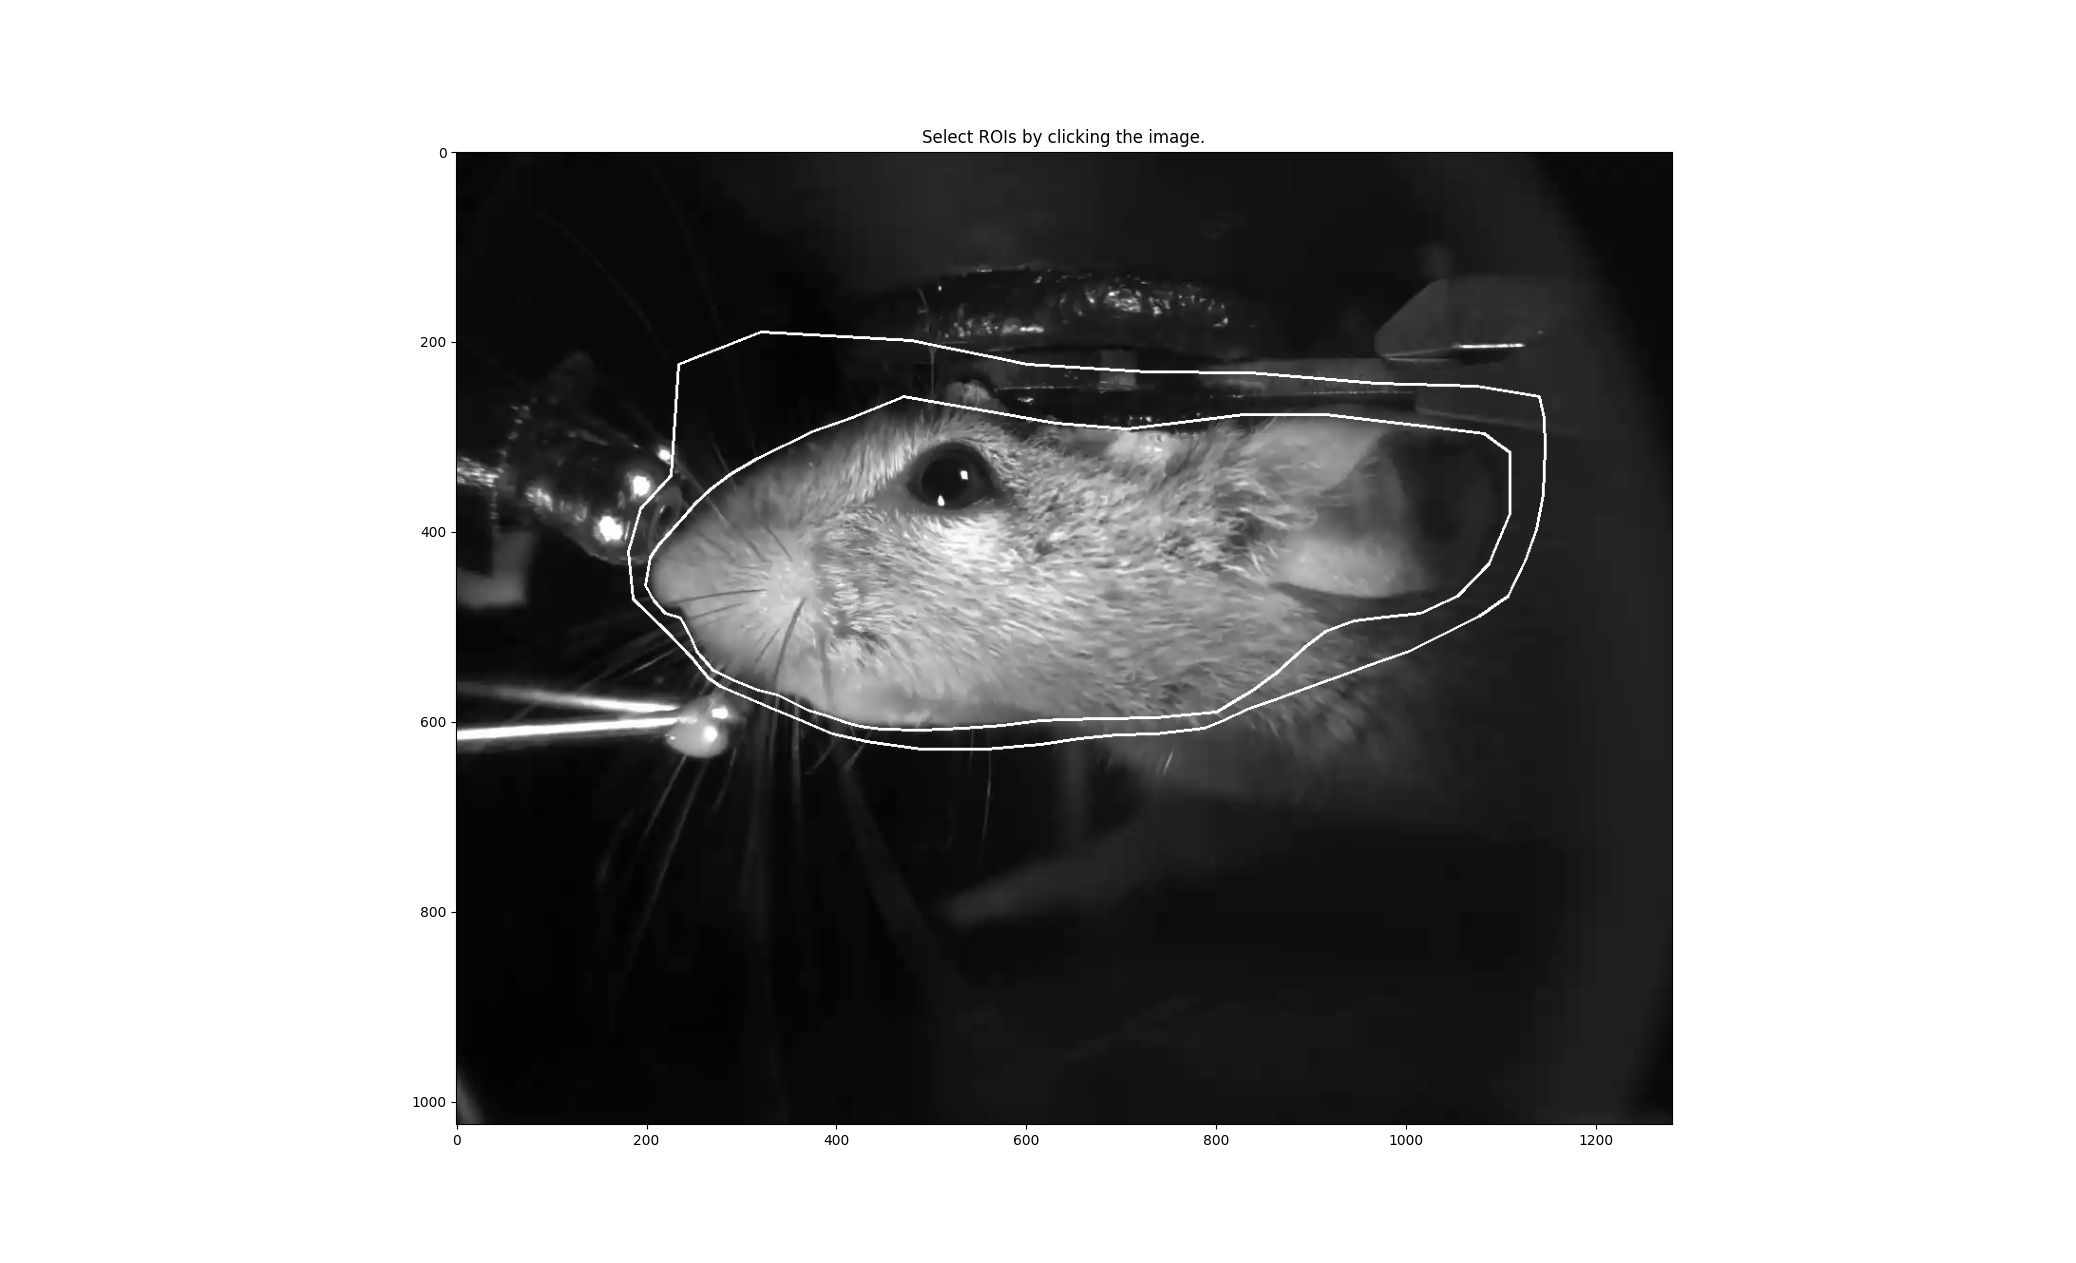

Button(description='Confirm ROI', style=ButtonStyle())

Button(description='New ROI', style=ButtonStyle())

mask_frames computed


In [26]:
exampleImage = data[0][0]
# %matplotlib notebook
rois = fr.rois.ROIs(
    select_mode='gui',
    exampleImage=exampleImage,
#     select_mode='file',
#     path_file=str(Path(directory_project) / 'analysis_files' / 'ROIs.h5'),
    path_file=r'/home/rich/Desktop/ROIs_7.h5',
    verbose=2
)

Make a point grid out of the first ROI

In [32]:
rois.make_points(rois=rois[0], point_spacing=10)

FR: Making points to track
FR: 2362 points total


Save the `ROIs` object in the 'analysis_files' project folder

In [33]:
rois.save_config(path_config=path_config, overwrite=True, verbose=1)
rois.save_run_info(path_config=path_config, overwrite=True, verbose=1)
rois.save_run_data(path_config=path_config, overwrite=True, verbose=1)

FR Warning: Overwriting field. 'ROIs' already in config.yaml.
FR Warning: Overwriting field. 'ROIs' is already a field in the run_info.json dictionary.
FR WARNING: path_run_data file is expected to be named 'ROIs.h5' if it is part of a project. Please make sure this is correct.
FR Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/churchland_data/from_20230429_slack/cam1/analysis_files/ROIs.h5 already exists.


visualize the ROIs

<IPython.core.display.Javascript object>


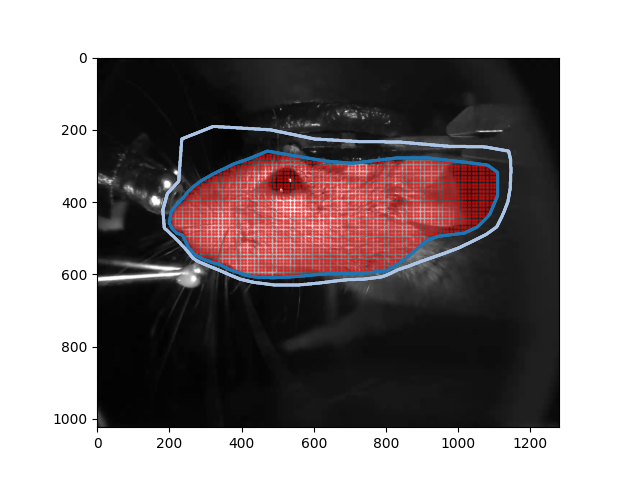

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [34]:
rois.plot_rois(exampleImage)

# Point Tracking

Prepare `PointTracker` object.\
Set `visualize_video` to **`True`** to tune parameters until they look appropriate, then set to **`False`** to run the full dataset through at a much faster speed.

Key parameters:
- `point_spacing`: distance between points. Vary so that total number of points is appropriate.
- `mesh_rigidity`: how rigid the mesh elasticity is. Vary so that points track well without drift.
- `relaxation`: how quickly the points relax back to their home position. Vary so that points track well without dift.
- `kwargs_method > winSize`: the spatial size of the optical flow calculation. Smaller is better but noisier, larger is less accurate but more robust to noise.
- `params_outlier_handling > threshold_displacement`: point displacements above this value will result in freezing of the points.

In [39]:
pt = fr.point_tracking.PointTracker(
#     buffered_video_reader=videos[:5],
    buffered_video_reader=videos,
    point_positions=rois.point_positions,
    rois_masks=[rois[1]],
    contiguous=False,
    params_optical_flow={
        "method": "lucas_kanade",
        "mesh_rigidity": 0.2,
        "mesh_n_neighbors": 30,
        "relaxation": 0.0030,
        "kwargs_method": {
            "winSize": [30,30],
            "maxLevel": 2,
            "criteria": [cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 2, 0.03],
        },        
    },
    visualize_video=False,
    params_visualization={
                'alpha':0.5,
                'point_sizes':2,
    },
    params_outlier_handling = {
        'threshold_displacement': 150,  ## Maximum displacement between frames, in pixels.
        'framesHalted_before': 3,  ## Number of frames to halt tracking before a violation.
        'framesHalted_after': 3,  ## Number of frames to halt tracking after a violation.
    },

    verbose=2,
)

FR: 2362 points will be tracked
FR: Collapsing mask ROI images into single mask
FR: Initializing mesh distances


Perform point tracking

In [ ]:
pt.track_points()

Save the `PointTracker` object in 'analysis_files' project directory.\
Using compression can reduce file sizes slightly but is very slow.

In [41]:
pt.save_config(path_config=path_config, overwrite=True, verbose=1)
pt.save_run_info(path_config=path_config, overwrite=True, verbose=2)
pt.save_run_data(path_config=path_config, overwrite=True, use_compression=False, verbose=1)

FR: Loading file /media/rich/bigSSD/analysis_data/face_rhythm/churchland_data/from_20230429_slack/cam1/run_info.json
FR: Adding 'PointTracker' field to run_info.json
FR: Saving run_info.json to /media/rich/bigSSD/analysis_data/face_rhythm/churchland_data/from_20230429_slack/cam1/run_info.json
FR WARNING: path_run_data file is expected to be named 'PointTracker.h5' if it is part of a project. Please make sure this is correct.


Clear some memory if needed. Optional.

In [42]:
pt.cleanup()

FR: Deleting all attributes


Load the `PointTracker` data as a dictionary

In [7]:
pt_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'PointTracker.h5'))
pt_data.unlazy()

# Spectral Analysis

Prepare `VQT_Analyzer` object.

Key parameters:
- `Q_lowF`:  Quality of the lowest frequency band of the spectrogram. Q value is number of oscillation periods.
- `Q_highF`: Quality of the highest frequency band...
- `F_min`: Lowest frequency band to use.
- `F_max`: Highest frequency band to use.
- `downsample_factor`: How much to downsample the spectrogram by in time.
- `return_complex`: Whether or not to return the complex spectrogram. Generally set to False unless you want to try something fancy.

<IPython.core.display.Javascript object>


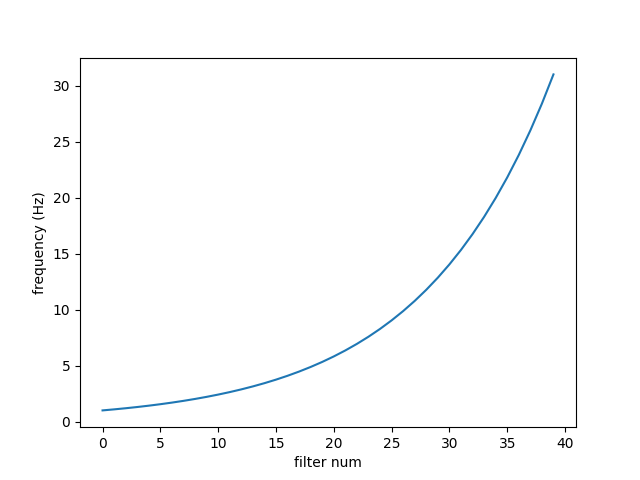

<IPython.core.display.Javascript object>


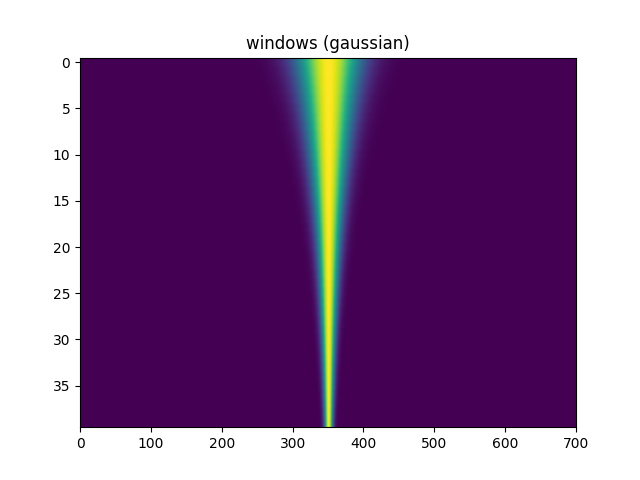

<IPython.core.display.Javascript object>


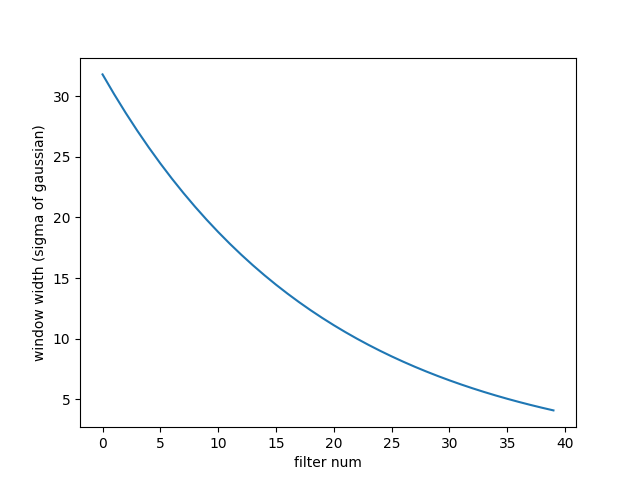

<IPython.core.display.Javascript object>


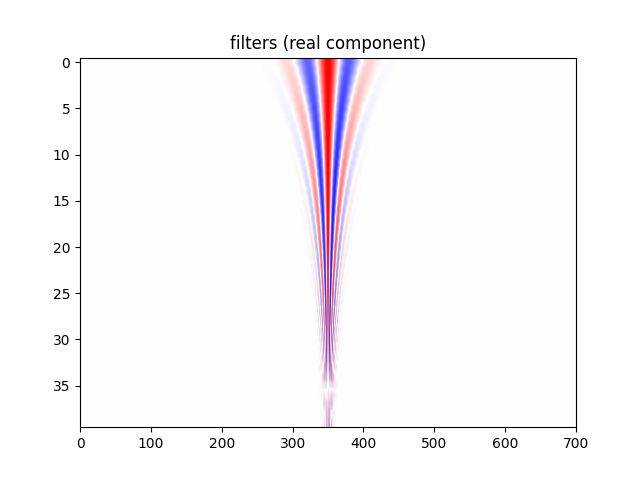

<IPython.core.display.Javascript object>


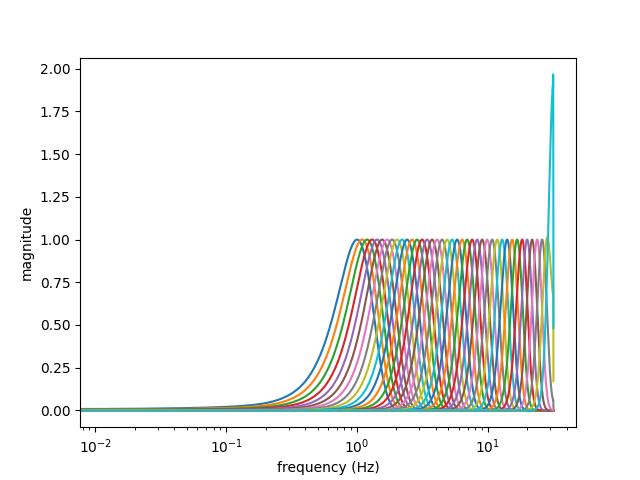

In [44]:
Fs = fr.util.load_run_info_file(path_run_info)['Dataset_videos']['frame_rate']

spec = fr.spectral_analysis.VQT_Analyzer(
    params_VQT = {
        'Fs_sample': Fs, 
        'Q_lowF': 2, 
        'Q_highF': 8, 
        'F_min': 1, 
        'F_max': int(data.frame_rate/2), 
        'n_freq_bins': 40, 
        'win_size': 701, 
        'plot_pref': True, 
        'downsample_factor': 20, 
        'padding': 'valid',
        'DEVICE_compute': 'cpu', 
        'batch_size': 10,
        'return_complex': False, 
        'progressBar': True
    },
    normalization_factor=0.95,
    spectrogram_exponent=1.0,
    one_over_f_exponent=0.5,
    verbose = 2,
)

Look at a demo spectrogram of a single point.\
Specify the point with the `idx_point` and `name_points` fields.\
Note that the `pt_data['points_tracked']` dictionary holds subdictionaries withe numeric string names (ie `['0'], ['1']`) for each video.

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]

Demo spectrogram shape: (2, 40, 8325)


<IPython.core.display.Javascript object>


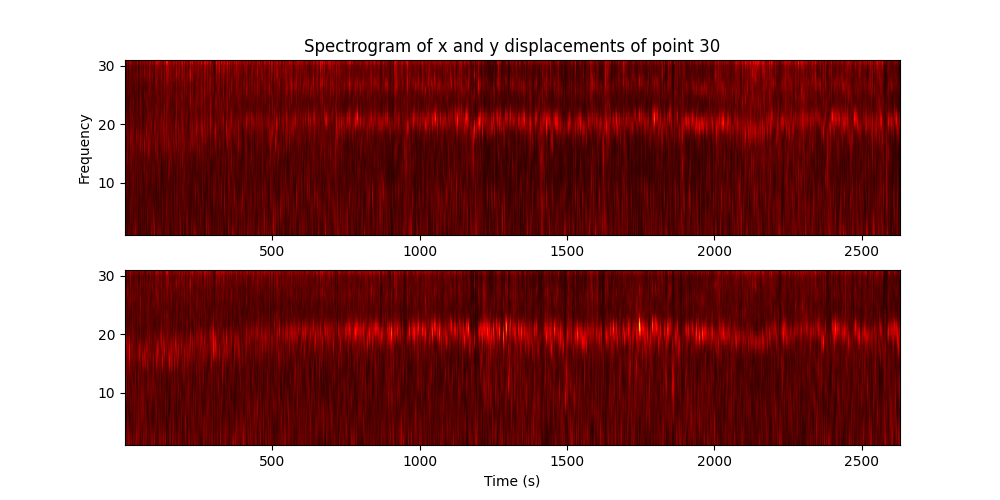

Total size of all spectrograms: 6.31806656 GB
Individual spectrogram sizes (in GB): [6.31806656]


In [45]:
test = spec.demo_transform(
    points_tracked=pt_data['points_tracked'],
    point_positions=pt_data['point_positions'],
    idx_point=30,
    name_points='0',
    plot=True,
);

Generate spectrograms

In [ ]:
spec.transform_all(
    points_tracked=pt_data['points_tracked'],
    point_positions=pt_data['point_positions'],
)

Save the `VQT_Analyzer` object in 'analysis_files' project directory.\
Using compression can reduce file sizes slightly but is very slow.

In [47]:
spec.save_config(path_config=path_config, overwrite=True, verbose=1)
spec.save_run_info(path_config=path_config, overwrite=True, verbose=1)
spec.save_run_data(path_config=path_config, overwrite=True, use_compression=False, verbose=1)

FR WARNING: path_run_data file is expected to be named 'VQT_Analyzer.h5' if it is part of a project. Please make sure this is correct.


Clear some memory if needed. Optional.

In [48]:
spec.cleanup()

FR: Deleting all attributes


Load the `VQT_Analyzer` data as a dictionary

In [49]:
spec_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'VQT_Analyzer.h5'))
spec_data.unlazy()

# Decomposition

Prepare `TCA` object, and then rearrange the data with the `.rearrange_data` method.

Key parameters for `.rearrange_data`:
- `names_dims_array`:  Enter the names of the dimensions of the spectrogram. Typically these are `'xy', 'points', 'frequency', 'time'`.
- `names_dims_concat_array`: Enter any dimensions you wish to concatenate along other dimensions. Typically we wish to concatenate the `'xy'` dimension along the `'points'` dimension, so we make a list containing that pair as a tuple: `[('xy', 'points')]`.
- `concat_complexDim`: If your input data are complex valued, then this can concatenate the complex dimension along another dimension.
- `name_dim_dictElements`: The `data` argument is expected to be a dictionary of dictionaries of arrays, where the inner dicts are trials or videos. This is the name of what those inner dicts are. Typically `'trials'`.

In [50]:
# spectrograms = spec_data['spectrograms']
spectrograms = {key: np.abs(val) for key,val in list(spec_data['spectrograms'].items())[:80]}

tca = fr.decomposition.TCA(verbose=2)

tca.rearrange_data(
    data=spectrograms,
    names_dims_array = ['xy', 'points', 'frequency', 'time'],
    names_dims_concat_array = [('xy', 'points')],
    concat_complexDim=False,
    name_dim_concat_complexDim='time',
    name_dim_dictElements = 'session',
    method_handling_dictElements = 'separate',
    name_dim_concat_dictElements = 'time',
    idx_windows=None,
    name_dim_array_window='time',
)

Preparing new names for the concatenated array dimensions. From ['xy', 'points', 'frequency', 'time'] to ['(xy points)', 'frequency', 'time'].
Rearranging the dict elements using method 'separate'.


Fit TCA model.

There are a few methods that can be used:
- `'CP_NN_HALS'`: non-negative CP decomposition using the efficient HALS algorithm. This should be used in most cases.
- `'CP'`: Standard CP decomposition. Use if input data are not non-negative (if you are using complex valued spectrograms or similar).
- `'Randomized_CP'`: Randomized CP decomposition. Allows for large input tensors. If you are using huge tensors and you are memory constrained or want to run on a small GPU, this is your only option.

If you have and want to use a CUDA compatible GPU:
- Set `DEVICE` to `'cuda'`
- GPU memory can be saved by setting `'init'` method to `'random'`. However, fastest convergence and highest accuracy typically come from `'init': 'svd'`.

In [51]:
tca.fit(
    method='CP_NN_HALS',
#     method='CP',
    params_method={
        'rank': 12, 
        'n_iter_max': 1000, 
        'init': 'random', 
        'svd': 'truncated_svd', 
        'tol': 1e-09, 
#         'nn_modes': [0,1], 
        'verbose': True, 
    },
    DEVICE='cuda:0',
    verbose=2,
)

Using device: cuda:0
Using method: <class 'tensorly.decomposition._nn_cp.CP_NN_HALS'>
Running the TCA model with method 'CP_NN_HALS'.


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/FR/lib/python3.9/site-packages/tensorly/backend/pytorch_backend.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=dtype, device=device,


reconstruction error=0.4949866235256195
iteration 1, reconstruction error: 0.35682255029678345, decrease = 0.13816407322883606
iteration 2, reconstruction error: 0.335805207490921, decrease = 0.021017342805862427
iteration 3, reconstruction error: 0.3300589323043823, decrease = 0.005746275186538696
iteration 4, reconstruction error: 0.32762476801872253, decrease = 0.00243416428565979
iteration 5, reconstruction error: 0.3263062834739685, decrease = 0.0013184845447540283
iteration 6, reconstruction error: 0.3254784047603607, decrease = 0.0008278787136077881
iteration 7, reconstruction error: 0.32490456104278564, decrease = 0.0005738437175750732
iteration 8, reconstruction error: 0.3244874179363251, decrease = 0.0004171431064605713
iteration 9, reconstruction error: 0.3241760730743408, decrease = 0.00031134486198425293
iteration 10, reconstruction error: 0.32393181324005127, decrease = 0.0002442598342895508
iteration 11, reconstruction error: 0.32372909784317017, decrease = 0.00020271539

iteration 93, reconstruction error: 0.3220098912715912, decrease = 3.606081008911133e-06
iteration 94, reconstruction error: 0.32200586795806885, decrease = 4.023313522338867e-06
iteration 95, reconstruction error: 0.3220020830631256, decrease = 3.7848949432373047e-06
iteration 96, reconstruction error: 0.3219982385635376, decrease = 3.844499588012695e-06
iteration 97, reconstruction error: 0.32199421525001526, decrease = 4.023313522338867e-06
iteration 98, reconstruction error: 0.32199060916900635, decrease = 3.606081008911133e-06
iteration 99, reconstruction error: 0.3219861686229706, decrease = 4.4405460357666016e-06
iteration 100, reconstruction error: 0.32198214530944824, decrease = 4.023313522338867e-06
iteration 101, reconstruction error: 0.32197830080986023, decrease = 3.844499588012695e-06
iteration 102, reconstruction error: 0.3219743072986603, decrease = 3.993511199951172e-06
iteration 103, reconstruction error: 0.3219698369503021, decrease = 4.470348358154297e-06
iteration 

iteration 184, reconstruction error: 0.32170650362968445, decrease = 4.470348358154297e-07
iteration 185, reconstruction error: 0.32170650362968445, decrease = 0.0
PARAFAC converged after 185 iterations


Rearrange the factors.\
You can undo the concatenation that was done during `.rearrange_data`

In [52]:
tca.rearrange_factors(
    undo_concat_complexDim=False,
    undo_concat_dictElements=False,
)

Save the `TCA` object in 'analysis_files' project directory.

In [53]:
tca.save_config(path_config=path_config, overwrite=True, verbose=1)
tca.save_run_info(path_config=path_config, overwrite=True, verbose=1)
tca.save_run_data(path_config=path_config, overwrite=True, use_compression=False, verbose=1)

FR WARNING: path_run_data file is expected to be named 'TCA.h5' if it is part of a project. Please make sure this is correct.


Clear some memory if needed. Useful if you ran the fit on a GPU. Optional.

In [54]:
tca._cleanup()

<IPython.core.display.Javascript object>


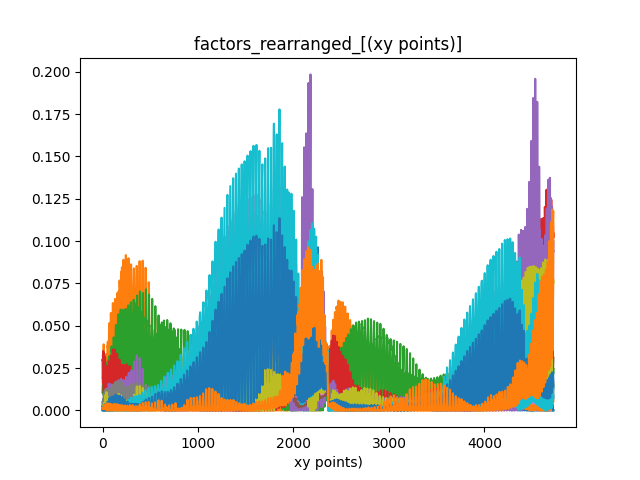

<IPython.core.display.Javascript object>


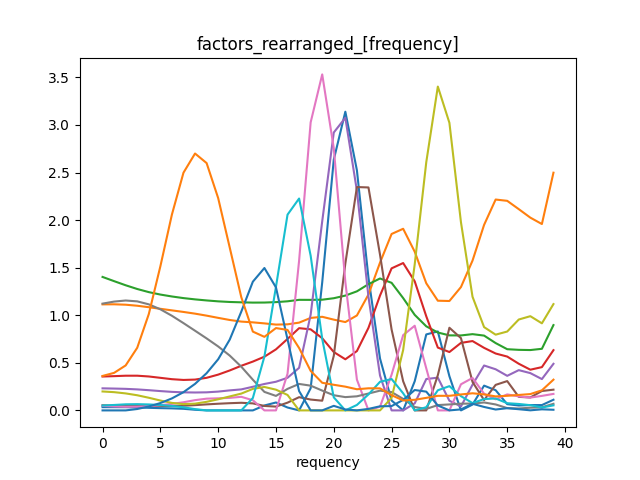

<IPython.core.display.Javascript object>


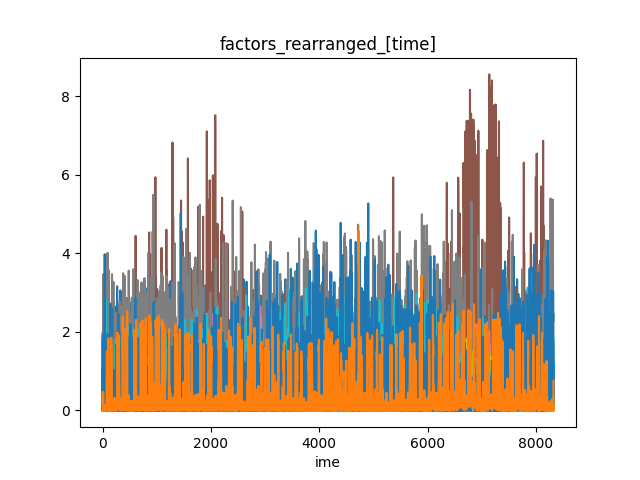

In [55]:
tca.plot_factors(
    figure_saver=None,
    show_figures=True,
)

Load the `TCA` data as a dictionary

In [8]:
tca_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'TCA.h5'))
tca_data.unlazy()

# Demo playback

Playback a video with points overlayed.\
Make sure you have a `BufferedVideoReader` object called `videos` made of your videos

In [ ]:
idx_video_to_use = 0
idx_frames_to_use = np.arange(8000,9000)

videos.method_getitem = 'by_video'

frame_visualizer = fr.visualization.FrameVisualizer(
    display=True,
    error_checking=True,
    verbose=2,
#     path_save=str(Path(directory_project) / 'visualizations' / 'point_tracking_demo.avi'),
    path_save=None,
    frame_height_width=videos.frame_height_width,
    frame_rate=data.frame_rate,
    point_sizes=3,
    points_colors=(0,255,255),
#     points_colors=[(cmap((factor_magnitudes / factor_magnitudes.max(0)))*255)[:,:,:3].astype(int).transpose(1,0,2)[0]],
    alpha=0.6,
)

fr.visualization.play_video_with_points(
    bufferedVideoReader=videos[idx_video_to_use],
    frameVisualizer=frame_visualizer,
    points=list(pt_data['points_tracked'].values())[0],
    idx_frames=idx_frames_to_use,
)